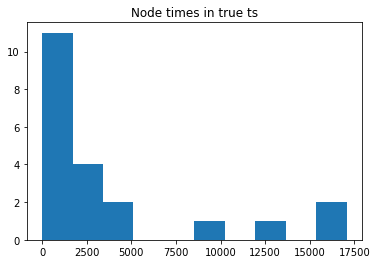

1592 mutations


In [20]:
import tsinfer
import msprime
import tskit
import tsdate

import numpy as np
import matplotlib.pyplot as plt

Ne = 10000
mu = 1e-8
historical_time = 5000
def generate_ts(
    Ne,
    mu,
    hist_time,
    rho=0, # default to no recombination
):
    samples = [
            msprime.SampleSet(1, time=hist_time, ploidy=1),
            msprime.SampleSet(5),
        ]
    mutated_ts = msprime.sim_ancestry(
        samples=samples,
        population_size=Ne,
        sequence_length=2e6,
        recombination_rate=rho,
        random_seed=1,
    )
    return msprime.mutate(mutated_ts, rate=mu, random_seed=1)

mutated_ts = generate_ts(Ne, mu, historical_time)
plt.hist(mutated_ts.nodes_time)
plt.title("Node times in true ts")
plt.show()
print(mutated_ts.num_mutations, "mutations")

In [25]:
prior = tsdate.build_prior_grid(mutated_ts, Ne=Ne, allow_historical_samples=True, truncate_priors=True, node_var_override={0:1000})

In [26]:
# Replace the prior for node 0 with a uniform prior over all timeslices
prior[0] = np.concatenate(([0],np.diff(prior.timepoints)/np.max(np.diff(prior.timepoints))))
hist_prior = prior[0].copy()

In [27]:
# date
dated_ts, posteriors = tsdate.date(mutated_ts, priors=prior, mutation_rate=mu, return_posteriors=True)

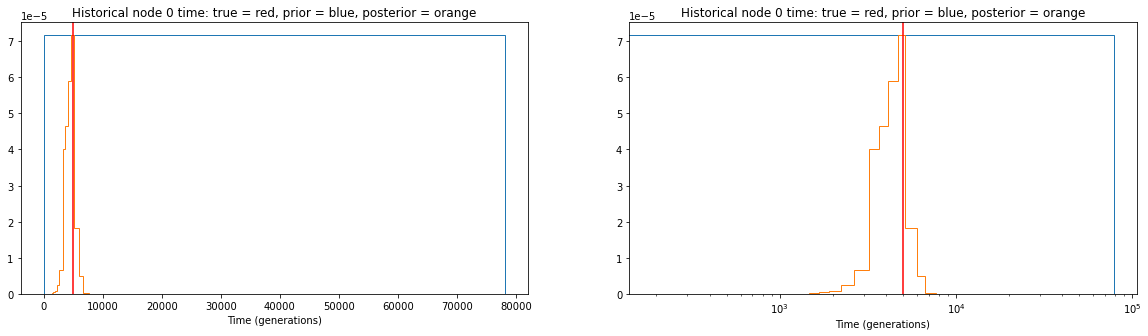

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
prior_pdf = hist_prior[1:]/np.diff(prior.timepoints)
max_prior = np.max(prior_pdf)
posterior_pdf = posteriors[0]/(posteriors['end_time'] - posteriors['start_time'])
for ax in axes:
    ax.stairs(prior_pdf, prior.timepoints)
    ax.stairs(posterior_pdf / max(posterior_pdf) * max_prior, np.concatenate((posteriors['start_time'][:1], posteriors['end_time'])))
    ax.axvline(historical_time, c="red")
    ax.set_title(f"Historical node 0 time: true = red, prior = blue, posterior = orange")
    ax.set_xlabel(f"Time ({dated_ts.time_units})")
axes[1].set_xscale("log")

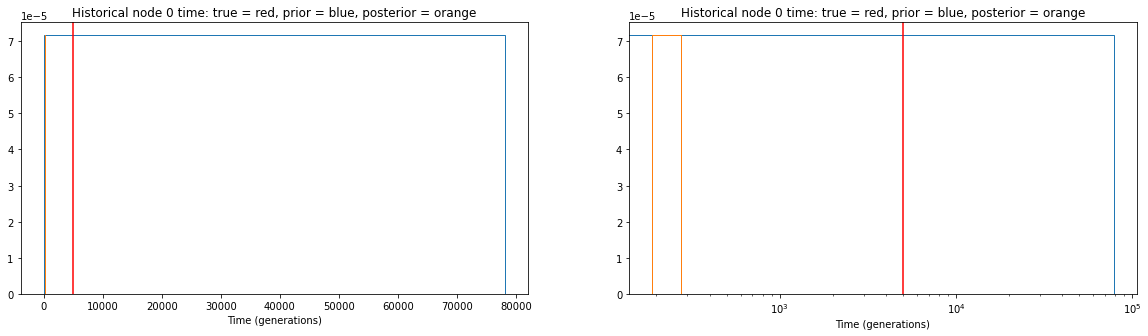

In [29]:
# repeat with rho=1e-9
mutated_ts = generate_ts(Ne, mu, historical_time, rho=5e-8)
prior = tsdate.build_prior_grid(mutated_ts, Ne=Ne, allow_historical_samples=True, truncate_priors=True, node_var_override={0:1000})
prior[0] = np.concatenate(([0],np.diff(prior.timepoints)/np.max(np.diff(prior.timepoints))))
hist_prior = prior[0].copy()
dated_ts, posteriors = tsdate.date(mutated_ts, priors=prior, mutation_rate=mu, return_posteriors=True)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
prior_pdf = hist_prior[1:]/np.diff(prior.timepoints)
max_prior = np.max(prior_pdf)
posterior_pdf = posteriors[0]/(posteriors['end_time'] - posteriors['start_time'])
for ax in axes:
    ax.stairs(prior_pdf, prior.timepoints)
    ax.stairs(posterior_pdf / max(posterior_pdf) * max_prior, np.concatenate((posteriors['start_time'][:1], posteriors['end_time'])))
    ax.axvline(historical_time, c="red")
    ax.set_title(f"Historical node 0 time: true = red, prior = blue, posterior = orange")
    ax.set_xlabel(f"Time ({dated_ts.time_units})")
axes[1].set_xscale("log")